In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
ROOT_PATH = '/gdrive/My Drive/Colab Notebooks/00_Lectures/Vision2/'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

training_data.shape =  (60000, 785) , test_data.shape =  (10000, 785)


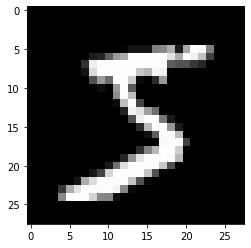

In [ ]:
training_data = np.loadtxt('{}{}/{}'.format(ROOT_PATH, 'data','mnist_train.csv'), delimiter=',' , dtype=np.float32)
test_data = np.loadtxt('{}{}/{}'.format(ROOT_PATH, 'data','mnist_test.csv'), delimiter=',' , dtype=np.float32)
print('training_data.shape = ', training_data.shape, ', test_data.shape = ', test_data.shape)

# image 로 나타내기 위해서는 2 열부터 마지막 열까지
# 총 784 개의 데이터를 28X28 행렬로 reshape 시켜주어야 함
image = training_data[ 0, 1: ].reshape(28,28)
plt.imshow(image, cmap='gray')
plt.show()

In [ ]:
# 외부함수 (external function)

# 0 또는 1 을 출력하기 위한 sigmoid 함수
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# 수치미분 이터레이터 version
def derivative(f, x):
		delta_x = 1e-4
		grad = np.zeros_like(x)
		# print("debug 1. initial input variable =", x)
		# print("debug 2. initial grad =", grad)
		# print("=======================================")

		it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])

		while not it.finished:
				idx = it.multi_index

				# print("debug 3. idx = ", idx, ", x[idx] = ", x[idx])

				tmp_val = x[idx]
				x[idx] = float(tmp_val) + delta_x
				fx1 = f(x) # f(x+delta_x)

				x[idx] = float(tmp_val) - delta_x
				fx2 = f(x) # f(x-delta_x)
				grad[idx] = (fx1 - fx2) / (2*delta_x)
    
				# print("debug 4. grad[idx] = ", grad[idx])
				# print("debug 5. grad = ", grad)
				# print("=======================================")

				x[idx] = tmp_val
				it.iternext()
		return grad    

In [ ]:
# MNIST_Test 클래스
class MNIST_Test:
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes

        # 은닉층 가중치 W2 Xavier/He 방법으로 self.W2 가중치 초기화
        self.W2 = np.random.randn(self.input_nodes, self.hidden_nodes) / np.sqrt(self.input_nodes/2)
        self.b2 = np.random.rand(self.hidden_nodes)

        # 출력층 가중치는 W3 Xavier/He 방법으로 self.W3 가중치 초기화
        self.W3 = np.random.randn(self.hidden_nodes, self.output_nodes) / np.sqrt(self.hidden_nodes/2)
        self.b3 = np.random.rand(self.output_nodes)

        # 학습률 learning rate 초기화
        self.learning_rate = learning_rate

    # 피드 포워드 함수
    def feed_forward(self):
        delta = 1e-7 # log 무한대 발산 방지
        z2 = np.dot(self.input_data, self.W2) + self.b2 # 은닉층 선형회귀 값
        a2 = sigmoid(z2) # 은닉층 출력
        z3 = np.dot(a2, self.W3) + self.b3 # 출력층 선형회귀 값
        y = a3 = sigmoid(z3) # 출력층 출력
        return -np.sum( self.target_data*np.log(y+delta) + (1-self.target_data)*np.log((1 - y)+delta) )

    # 손실 값 계산
    def loss_val(self):
        delta = 1e-7 # log 무한대 발산 방지
        z2 = np.dot(self.input_data, self.W2) + self.b2 # 은닉층 선형회귀 값
        a2 = sigmoid(z2) # 은닉층 출력
        z3 = np.dot(a2, self.W3) + self.b3 # 출력층 선형회귀 값
        y = a3 = sigmoid(z3) # 출력층 출력
        return -np.sum( self.target_data*np.log(y+delta) + (1-self.target_data)*np.log((1 - y)+delta) )

  
    # 수치미분을 이용하여 손실함수가 최소가 될때 까지 학습하는 함수
    def train(self, input_data, target_data):
        self.input_data = input_data
        self.target_data = target_data

        f = lambda x : self.feed_forward()

        self.W2 -= self.learning_rate * derivative(f, self.W2)
        self.b2 -= self.learning_rate * derivative(f, self.b2)
        self.W3 -= self.learning_rate * derivative(f, self.W3)
        self.b3 -= self.learning_rate * derivative(f, self.b3)
    
    
    # 미래 값 예측 함수
    def predict(self, input_data):
        z2 = np.dot(input_data, self.W2) + self.b2
        a2 = sigmoid(z2)
        z3 = np.dot(a2, self.W3) + self.b3
        y = a3 = sigmoid(z3)

        # MNIST 경우는 one-hot encoding 을 적용하기 때문에
        # 0 또는 1 이 아닌 argmax() 를 통해 최대 인덱스를 넘겨주어야 함
        predicted_num = np.argmax(y)

        return predicted_num
    
    
    # 정확도 측정 함수
    def accuracy(self, input_data, target_data):
        matched_list = []
        not_matched_list = []

        for index in range(len(input_data)):
            label = int(target_data[index])

            # 정규화(normalize)
            data = (input_data[index, :] / 255.0 * 0.99) + 0.01
            predicted_num = self.predict(data)

            if label == predicted_num:
                matched_list.append(index)

            else:
                not_matched_list.append(index)

        print("Current Accuracy = ", len(matched_list)/(len(input_data)) )
        return matched_list, not_matched_list

In [ ]:
# training_data = np.loadtxt('./mnist_train.csv', delimiter=',', dtype=np.float32)

i_nodes = training_data.shape[1] - 1 # input nodes 개수
h1_nodes = 30 # hidden nodes 개수.
o_nodes = 10 # output nodes 개수
lr = 1e-2 # learning rate
epochs = 1 # 반복횟수

# MNIST_Test 객체 생성
obj = MNIST_Test(i_nodes, h1_nodes, o_nodes, lr)

for step in range(epochs):
    for index in range(len(training_data)):      
        # input_data, target_data normalize
        input_data = ((training_data[index, 1:] / 255.0) * 0.99) + 0.01
        target_data = np.zeros(o_nodes) + 0.01
        target_data[int(training_data[index, 0])] = 0.99

        obj.train(input_data, target_data)

        if (index % 200 == 0):
            print("epochs = ", step, ", index = ", index, ", loss value = ", obj.loss_val())

In [ ]:
# test_data = np.loadtxt('./mnist_test.csv', delimiter=',', dtype=np.float32)
test_input_data = test_data[ : , 1: ]
test_target_data = test_data[ : , 0 ]
(true_list_1, false_list_1) = obj.accuracy(test_input_data, test_target_data)